In [30]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CWLITEARM'
CRYPTO_TARGET='TINYAES128C'
SS_VER='SS_VER_1_1'

In [31]:
%run "Setup_Scripts/Setup_Generic.ipynb"

INFO: Found ChipWhisperer😍


In [32]:
NO_OF_PLAINTEXTS = 50
scope.adc.samples = 4200

In [33]:
import random
import string

plaintexts = []
plaintexts = [[random.randint(0, 255) for _ in range(8)] for _ in range(NO_OF_PLAINTEXTS)]

## Orginal

In [34]:
%%bash -s "$PLATFORM" "$CRYPTO_TARGET" "$SS_VER"
cd ../hardware/victims/firmware/simpleserial-blowfish
make PLATFORM=$1 CRYPTO_TARGET=NONE SS_VER=$3 -j
#make clean

SS_VER set to SS_VER_1_1
make clean_objs .dep 
make[1]: Entering directory '/home/vagrant/work/projects/chipwhisperer/hardware/victims/firmware/simpleserial-blowfish'
SS_VER set to SS_VER_1_1
rm -f -- simpleserial-blowfish-CWLITEARM.hex
make[1]: '.dep' is up to date.
rm -f -- simpleserial-blowfish-CWLITEARM.eep
rm -f -- simpleserial-blowfish-CWLITEARM.cof
rm -f -- simpleserial-blowfish-CWLITEARM.elf
rm -f -- simpleserial-blowfish-CWLITEARM.map
rm -f -- simpleserial-blowfish-CWLITEARM.sym
rm -f -- simpleserial-blowfish-CWLITEARM.lss
rm -f -- objdir-CWLITEARM/*.o
rm -f -- objdir-CWLITEARM/*.lst
rm -f -- simpleserial-blowfish.s simpleserial.s stm32f3_hal.s stm32f3_hal_lowlevel.s stm32f3_sysmem.s
rm -f -- simpleserial-blowfish.d simpleserial.d stm32f3_hal.d stm32f3_hal_lowlevel.d stm32f3_sysmem.d
rm -f -- simpleserial-blowfish.i simpleserial.i stm32f3_hal.i stm32f3_hal_lowlevel.i stm32f3_sysmem.i
make[1]: Leaving directory '/home/vagrant/work/projects/chipwhisperer/hardware/victims/firmwar

simpleserial-blowfish.c: In function 'get_pt':
simpleserial-blowfish.c:50:10: warning: pointer targets in passing argument 1 of 'strncpy' differ in signedness [-Wpointer-sign]
  strncpy(data, pt, sizeof(data));
          ^~~~
In file included from blowfish.c:2,
                 from simpleserial-blowfish.c:24:
/usr/include/newlib/string.h:44:8: note: expected 'char * restrict' but argument is of type 'uint8_t *' {aka 'unsigned char *'}
 char  *strncpy (char *__restrict, const char *__restrict, size_t);
        ^~~~~~~
simpleserial-blowfish.c:50:16: warning: pointer targets in passing argument 2 of 'strncpy' differ in signedness [-Wpointer-sign]
  strncpy(data, pt, sizeof(data));
                ^~
In file included from blowfish.c:2,
                 from simpleserial-blowfish.c:24:
/usr/include/newlib/string.h:44:8: note: expected 'const char * restrict' but argument is of type 'uint8_t *' {aka 'unsigned char *'}
 char  *strncpy (char *__restrict, const char *__restrict, size_t);
     

+--------------------------------------------------------
+ Built for platform CW-Lite Arm \(STM32F3\) with:
+ Default target does full rebuild each time.
+ CRYPTO_TARGET = NONE
+ Specify buildtarget == allquick == to avoid full rebuild
+ CRYPTO_OPTIONS = 
+--------------------------------------------------------
+--------------------------------------------------------
.
Linking: simpleserial-blowfish-CWLITEARM.elf
arm-none-eabi-gcc -mcpu=cortex-m4 -I. -mthumb -mfloat-abi=soft -fmessage-length=0 -ffunction-sections -gdwarf-2 -DSS_VER=SS_VER_1_1 -DSTM32F303xC -DSTM32F3 -DSTM32 -DDEBUG -DHAL_TYPE=HAL_stm32f3 -DPLATFORM=CWLITEARM -DF_CPU=7372800UL -DSS_VER_2_0=2 -DSS_VER_2_1=3 -DSS_VER_1_1=1 -DSS_VER_1_0=0 -Os -funsigned-char -funsigned-bitfields -fshort-enums -Wall -Wstrict-prototypes -Wa,-adhlns=objdir-CWLITEARM/simpleserial-blowfish.o -I.././simpleserial/ -I.././hal -I.././hal/stm32f3 -I.././hal/stm32f3/CMSIS -I.././hal/stm32f3/CMSIS/core -I.././hal/stm32f3/CMSIS/device -I.././hal/stm

In [35]:
cw.program_target(scope, prog, "../hardware/victims/firmware/simpleserial-blowfish/simpleserial-blowfish-{}.hex".format(PLATFORM))

Detected known STMF32: STM32F302xB(C)/303xB(C)
Extended erase (0x44), this can take ten seconds or more
Attempting to program 12851 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 12851 bytes


In [36]:
from tqdm.notebook import trange
import numpy as np
import time

ktp = cw.ktp.Basic()
trace_array_orginal = []
textin_array = []

# target.set_key(key)
for i in trange(NO_OF_PLAINTEXTS, desc='Capturing traces'):
    scope.arm()
    
    target.simpleserial_write('p', bytearray(plaintexts[i]))
    
    ret = scope.capture()
    if ret:
        print("Target timed out!")
        continue
    
    response = target.simpleserial_read('r', 8)
    
    trace_array_orginal.append(scope.get_last_trace())

trace_array_orginal = np.array(trace_array_orginal)

Capturing traces:   0%|          | 0/50 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


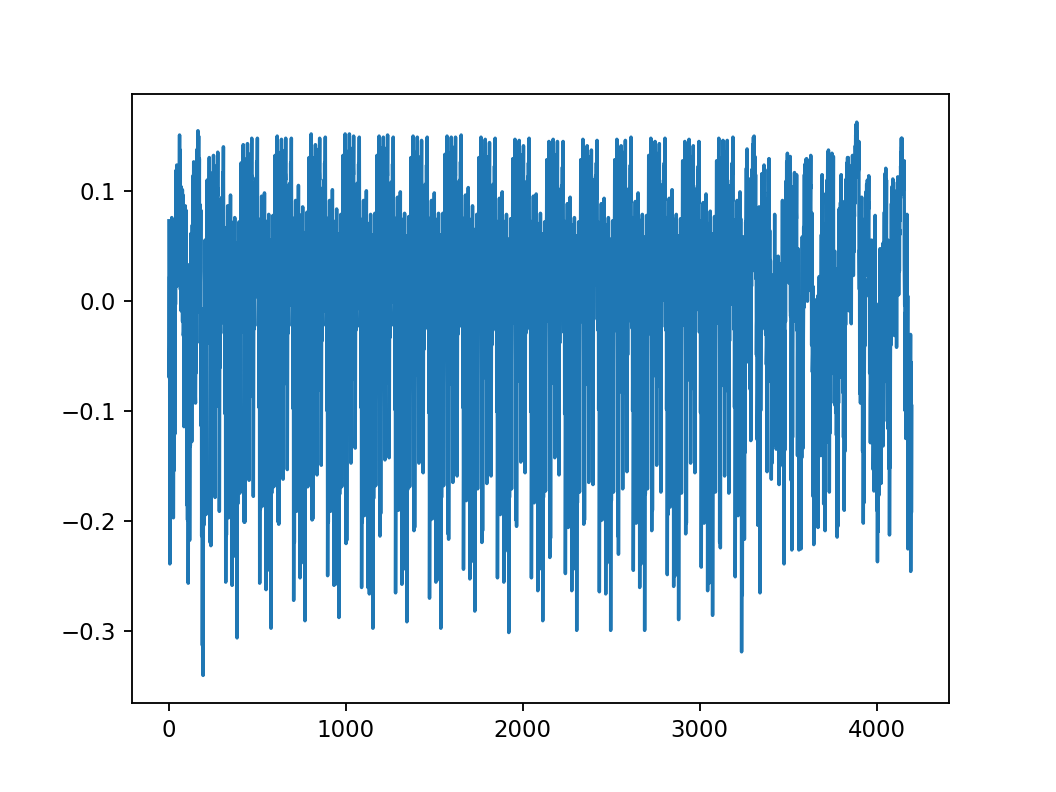

In [37]:
%matplotlib notebook
import matplotlib.pylab as plt

plt.plot(trace_array_orginal[0]) # Orginal blowfish
plt.show()

## Dummy func
Dummy Code in blowfish.c

In [49]:
%%bash -s "$PLATFORM" "$CRYPTO_TARGET" "$SS_VER"
cd ../hardware/victims/firmware/simpleserial-blowfish
make PLATFORM=$1 CRYPTO_TARGET=NONE SS_VER=$3 -j
#make clean

SS_VER set to SS_VER_1_1
make clean_objs .dep 
make[1]: Entering directory '/home/vagrant/work/projects/chipwhisperer/hardware/victims/firmware/simpleserial-blowfish'
SS_VER set to SS_VER_1_1
rm -f -- simpleserial-blowfish-CWLITEARM.hex
make[1]: '.dep' is up to date.
rm -f -- simpleserial-blowfish-CWLITEARM.eep
rm -f -- simpleserial-blowfish-CWLITEARM.cof
rm -f -- simpleserial-blowfish-CWLITEARM.elf
rm -f -- simpleserial-blowfish-CWLITEARM.map
rm -f -- simpleserial-blowfish-CWLITEARM.sym
rm -f -- simpleserial-blowfish-CWLITEARM.lss
rm -f -- objdir-CWLITEARM/*.o
rm -f -- objdir-CWLITEARM/*.lst
rm -f -- simpleserial-blowfish.s simpleserial.s stm32f3_hal.s stm32f3_hal_lowlevel.s stm32f3_sysmem.s
rm -f -- simpleserial-blowfish.d simpleserial.d stm32f3_hal.d stm32f3_hal_lowlevel.d stm32f3_sysmem.d
rm -f -- simpleserial-blowfish.i simpleserial.i stm32f3_hal.i stm32f3_hal_lowlevel.i stm32f3_sysmem.i
make[1]: Leaving directory '/home/vagrant/work/projects/chipwhisperer/hardware/victims/firmwar

simpleserial-blowfish.c: In function 'get_pt':
simpleserial-blowfish.c:50:10: warning: pointer targets in passing argument 1 of 'strncpy' differ in signedness [-Wpointer-sign]
  strncpy(data, pt, sizeof(data));
          ^~~~
In file included from blowfish.c:2,
                 from simpleserial-blowfish.c:24:
/usr/include/newlib/string.h:44:8: note: expected 'char * restrict' but argument is of type 'uint8_t *' {aka 'unsigned char *'}
 char  *strncpy (char *__restrict, const char *__restrict, size_t);
        ^~~~~~~
simpleserial-blowfish.c:50:16: warning: pointer targets in passing argument 2 of 'strncpy' differ in signedness [-Wpointer-sign]
  strncpy(data, pt, sizeof(data));
                ^~
In file included from blowfish.c:2,
                 from simpleserial-blowfish.c:24:
/usr/include/newlib/string.h:44:8: note: expected 'const char * restrict' but argument is of type 'uint8_t *' {aka 'unsigned char *'}
 char  *strncpy (char *__restrict, const char *__restrict, size_t);
     

+--------------------------------------------------------
.
Linking: simpleserial-blowfish-CWLITEARM.elf
arm-none-eabi-gcc -mcpu=cortex-m4 -I. -mthumb -mfloat-abi=soft -fmessage-length=0 -ffunction-sections -gdwarf-2 -DSS_VER=SS_VER_1_1 -DSTM32F303xC -DSTM32F3 -DSTM32 -DDEBUG -DHAL_TYPE=HAL_stm32f3 -DPLATFORM=CWLITEARM -DF_CPU=7372800UL -DSS_VER_2_0=2 -DSS_VER_2_1=3 -DSS_VER_1_1=1 -DSS_VER_1_0=0 -Os -funsigned-char -funsigned-bitfields -fshort-enums -Wall -Wstrict-prototypes -Wa,-adhlns=objdir-CWLITEARM/simpleserial-blowfish.o -I.././simpleserial/ -I.././hal -I.././hal/stm32f3 -I.././hal/stm32f3/CMSIS -I.././hal/stm32f3/CMSIS/core -I.././hal/stm32f3/CMSIS/device -I.././hal/stm32f4/Legacy -I.././crypto/ -std=gnu99  -MMD -MP -MF .dep/simpleserial-blowfish-CWLITEARM.elf.d objdir-CWLITEARM/simpleserial-blowfish.o objdir-CWLITEARM/simpleserial.o objdir-CWLITEARM/stm32f3_hal.o objdir-CWLITEARM/stm32f3_hal_lowlevel.o objdir-CWLITEARM/stm32f3_sysmem.o objdir-CWLITEARM/stm32f3_startup.o --outpu

In [50]:
cw.program_target(scope, prog, "../hardware/victims/firmware/simpleserial-blowfish/simpleserial-blowfish-{}.hex".format(PLATFORM))

Detected known STMF32: STM32F302xB(C)/303xB(C)
Extended erase (0x44), this can take ten seconds or more
Attempting to program 20299 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 20299 bytes


In [51]:
from tqdm.notebook import trange
import numpy as np
import time

ktp = cw.ktp.Basic()
trace_array_dummy = []

# target.set_key(key)
for i in trange(NO_OF_PLAINTEXTS, desc='Capturing traces'):
    scope.arm()
    
    target.simpleserial_write('p', bytearray(plaintexts[i]))
    
    ret = scope.capture()
    if ret:
        print("Target timed out!")
        continue
    
    response = target.simpleserial_read('r', 8)
    
    trace_array_dummy.append(scope.get_last_trace())

trace_array_dummy = np.array(trace_array_dummy)

Capturing traces:   0%|          | 0/50 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


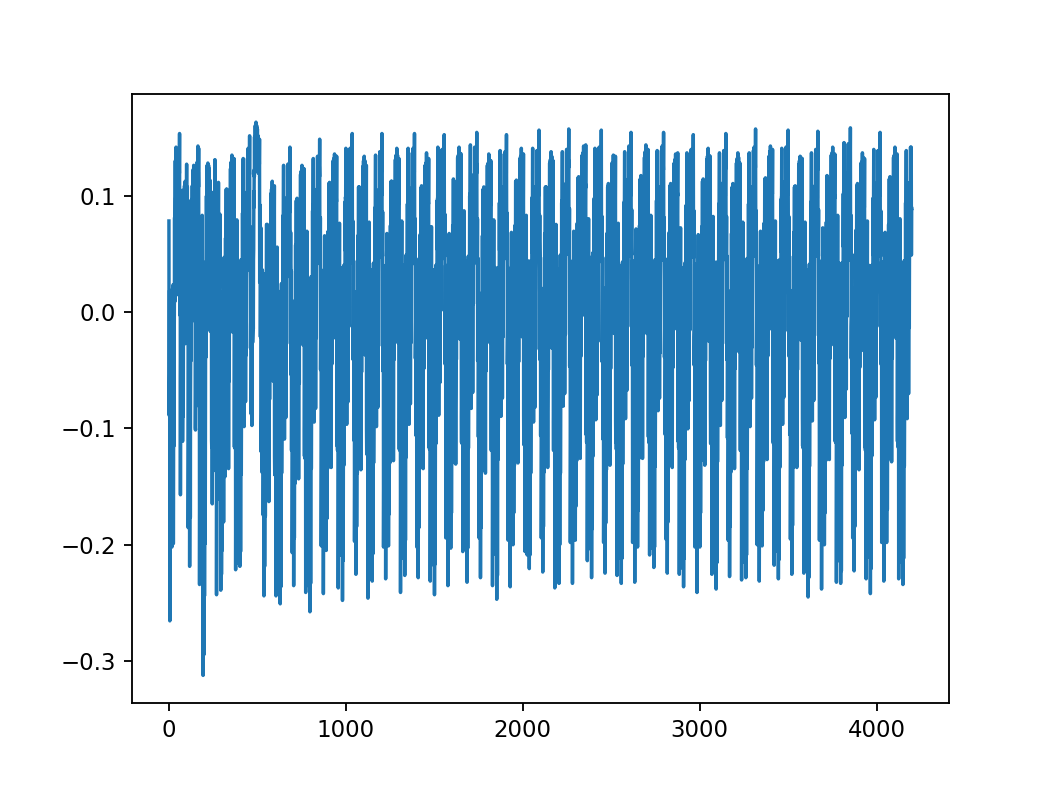

In [52]:
%matplotlib notebook
import matplotlib.pylab as plt

plt.plot(trace_array_dummy[0]) # Dummy Fuc x2
plt.show()

<IPython.core.display.Javascript object>


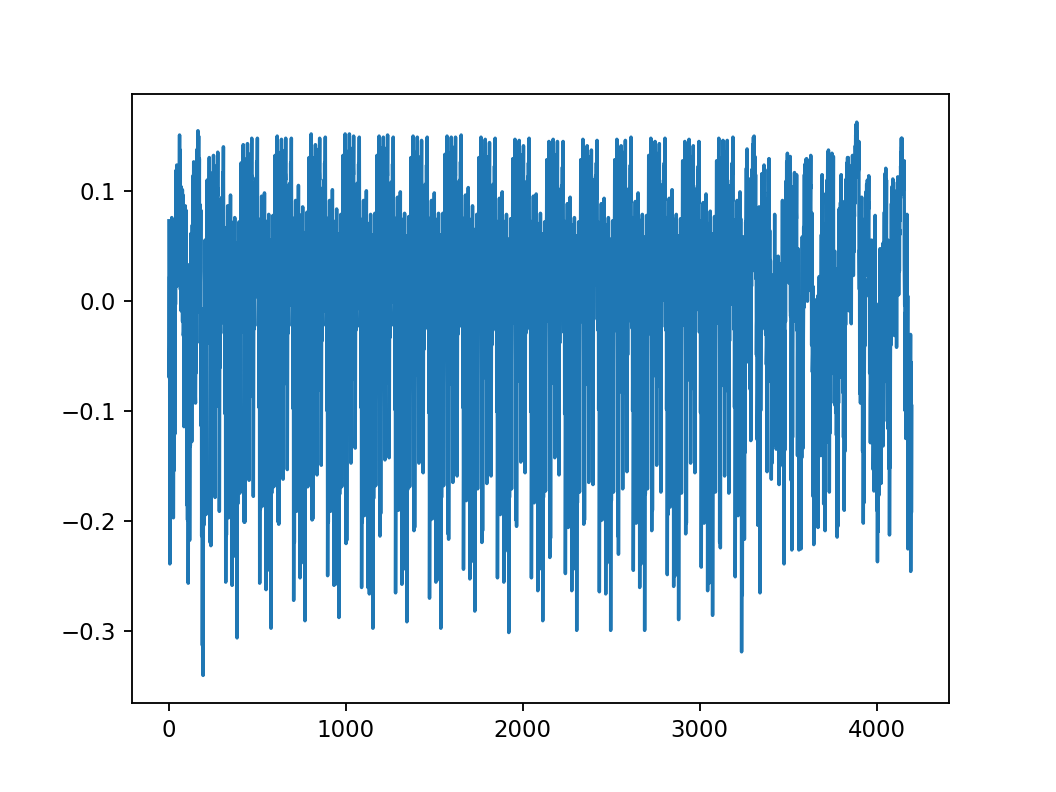

In [54]:
%matplotlib notebook
import matplotlib.pylab as plt

plt.plot(trace_array_orginal[0]) # Orginal blowfish
plt.show()

## T-Test

In [53]:
from scipy import stats

# T-Test über Orginal - Dummy (2 dummy func feistel_function & _encypt)

for i in range(NO_OF_PLAINTEXTS):
    print(stats.ttest_ind(trace_array_orginal[i], trace_array_dummy[i], equal_var = False))
    print(np.var(trace_array_orginal[i]), np.var(trace_array_dummy[i]))

Ttest_indResult(statistic=0.298930256584067, pvalue=0.7650006632264119)
0.008692858776862386 0.009201225062562764
Ttest_indResult(statistic=0.15521791764275145, pvalue=0.8766532566583723)
0.008663451024788578 0.009176782825149917
Ttest_indResult(statistic=0.24548905922319164, pvalue=0.8060837814672195)
0.00860136216589653 0.009071219693830495
Ttest_indResult(statistic=0.2710857625251415, pvalue=0.7863317382181767)
0.008612768042601155 0.009047330186750883
Ttest_indResult(statistic=0.24846507248131777, pvalue=0.8037806727765715)
0.008547759252827183 0.009120663649316818
Ttest_indResult(statistic=0.011466417260128365, pvalue=0.9908515957721875)
0.008551414792013276 0.009061638329088552
Ttest_indResult(statistic=0.2087661379008524, pvalue=0.8346358736420273)
0.008582006376400556 0.009052483967156095
Ttest_indResult(statistic=0.20954709099154958, pvalue=0.8340262647297844)
0.008554833347240543 0.009043715145258136
Ttest_indResult(statistic=0.1815594316999329, pvalue=0.8559328757955786)
0.0

In [70]:
from scipy import stats

# T-Test über Orginal - Dummy (1 function in feistel_function)

for i in range(NO_OF_PLAINTEXTS):
    print(stats.ttest_ind(trace_array_orginal[i], trace_array_dummy[i], equal_var = False))
    print(np.var(trace_array_orginal[i]), np.var(trace_array_dummy[i]))

Ttest_indResult(statistic=-0.15614070040738623, pvalue=0.8759252700753415)
0.009016712794647217 0.008888884983787537
Ttest_indResult(statistic=-0.3225866602069247, pvalue=0.7470150431900122)
0.008991709924163819 0.008904062557640076
Ttest_indResult(statistic=-0.2386832698409207, pvalue=0.8113560826298867)
0.009045560742797852 0.008940088536224366
Ttest_indResult(statistic=-0.43279734935450365, pvalue=0.6651713358860769)
0.008996828818321229 0.008791149596214293
Ttest_indResult(statistic=-0.41202941816646976, pvalue=0.6803266946255425)
0.008997945566978456 0.008893697287597657
Ttest_indResult(statistic=-0.33655842441229333, pvalue=0.7364568676402591)
0.009027009467124938 0.008722520642700196
Ttest_indResult(statistic=-0.10783979671588557, pvalue=0.9141249377725416)
0.009024660330162047 0.008882126954803468
Ttest_indResult(statistic=-0.4233239285003191, pvalue=0.6720680451018871)
0.009019750717773436 0.008816076473846435
Ttest_indResult(statistic=-0.3653664881221844, pvalue=0.71484558521

In [71]:
from scipy import stats

# T-Test über Orginal - Orginal 

for i in range(NO_OF_PLAINTEXTS):
    print(stats.ttest_ind(trace_array_orginal[i], trace_array_orginal[i], equal_var = False))
    
    print(np.var(trace_array_orginal[i]), np.var(trace_array_orginal[i]))

Ttest_indResult(statistic=0.0, pvalue=1.0)
0.009016712794647217 0.009016712794647217
Ttest_indResult(statistic=0.0, pvalue=1.0)
0.008991709924163819 0.008991709924163819
Ttest_indResult(statistic=0.0, pvalue=1.0)
0.009045560742797852 0.009045560742797852
Ttest_indResult(statistic=0.0, pvalue=1.0)
0.008996828818321229 0.008996828818321229
Ttest_indResult(statistic=0.0, pvalue=1.0)
0.008997945566978456 0.008997945566978456
Ttest_indResult(statistic=0.0, pvalue=1.0)
0.009027009467124938 0.009027009467124938
Ttest_indResult(statistic=0.0, pvalue=1.0)
0.009024660330162047 0.009024660330162047
Ttest_indResult(statistic=0.0, pvalue=1.0)
0.009019750717773436 0.009019750717773436
Ttest_indResult(statistic=0.0, pvalue=1.0)
0.009024383787193299 0.009024383787193299
Ttest_indResult(statistic=0.0, pvalue=1.0)
0.008977081706199645 0.008977081706199645
Ttest_indResult(statistic=0.0, pvalue=1.0)
0.008931222728729248 0.008931222728729248
Ttest_indResult(statistic=0.0, pvalue=1.0)
0.009005074721336366 0

In [ ]:
#disconnect
scope.dis()
target.dis()